<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer 

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer 
from pymystem3 import Mystem

import re 

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix




import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


# Лемматизация

In [5]:
corpus = list(data['text'])

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [9]:
def clear_text(text):
    rec = re.sub(r"[^'a-zA-Z ]", ' ', text) 
    clear = " ".join(rec.split())
    return clear

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
test = "Parrots, which are exotic and unusual animals, sometimes can be found in pet-shops or zoos"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(test)])

['Parrots', ',', 'which', 'be', 'exotic', 'and', 'unusual', 'animal', ',', 'sometimes', 'can', 'be', 'found', 'in', 'pet-shops', 'or', 'zoo']


In [12]:
%%time
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 

lemy=[]
for i in tqdm(range(len(corpus))):
    
    lemy.append(lemmafunction(clear_text(corpus[i])))
data['lemm_text']=pd.Series(lemy, index=data.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 15min 40s, sys: 1min 35s, total: 17min 16s
Wall time: 17min 39s


In [13]:
data['text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [14]:
data['lemm_text'][3]

"More I ca n't make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know There appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up It 's list in the relevant form eg Wikipedia Good article nomination Transport"

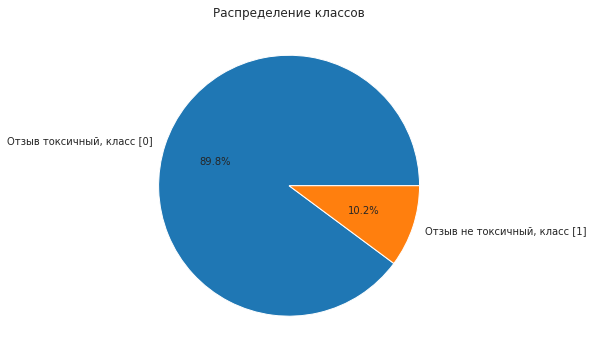

In [11]:
sns.set_style('darkgrid')
data['toxic'].value_counts(normalize=True).plot(kind='pie', figsize=[10,6], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Распределение классов')

plt.ylabel('')
plt.show()

In [12]:
#Разделим выборки
#data = data.drop(labels = [34],axis = 0)
X = data.drop('toxic', axis=1) 
y = data['toxic']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5,random_state=12345)

In [14]:
train_sample = X_train.shape[0]/X.shape[0]
test_sample = X_test.shape[0]/X.shape[0]
valid_sample = X_valid.shape[0]/X.shape[0]

print('Размер тренировочной выборки- {:.5%}'.format(train_sample))
print('Размер тестовой выборки - {:.5%}'.format(test_sample))
print('Размер валидационной выборки - {:.5%}'.format(valid_sample))

Размер тренировочной выборки- 65.99955%
Размер тестовой выборки - 17.00023%
Размер валидационной выборки - 17.00023%


In [15]:
X_test.shape

(27080, 3)

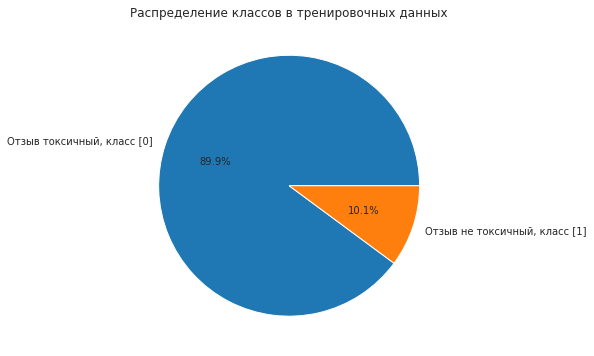

In [16]:
#распределение классов в тренировочной выборке
y_train.value_counts(normalize=True).plot(kind='pie', figsize=[10,6], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Распределение классов в тренировочных данных')
plt.ylabel('')
plt.show()

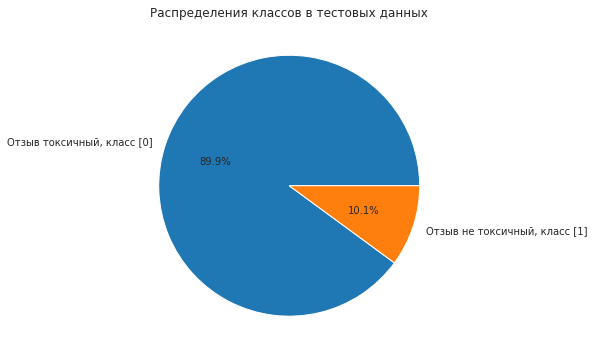

In [17]:
#распределение классов в тестовой выборке
y_test.value_counts(normalize=True).plot(kind='pie',figsize=[10,6], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Распределения классов в тестовых данных')
plt.ylabel('')
plt.show()

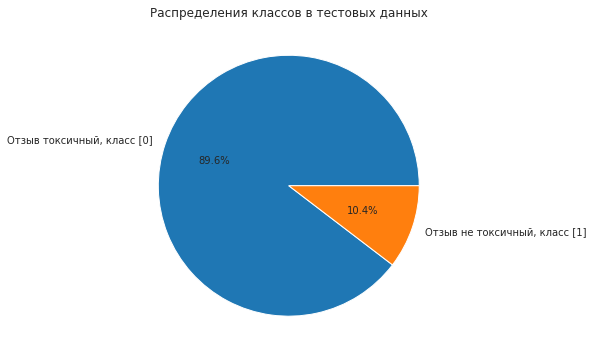

In [18]:
#распределение классов в валидационной выборке
y_valid.value_counts(normalize=True).plot(kind='pie',figsize=[10,6], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Распределения классов в тестовых данных')
plt.ylabel('')
plt.show()

In [19]:
def down_up_sample(features, target, fraction, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down_up = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]*repeat)
    target_down_up = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]*repeat)
    
    features_down_up_sampled, target_down_up_sampled = shuffle(
        features_down_up, target_down_up, random_state=12345)
    
    return features_down_up_sampled, target_down_up_sampled

features_upsampled, target_upsampled  = down_up_sample(X_train, y_train, 0.6, 5)

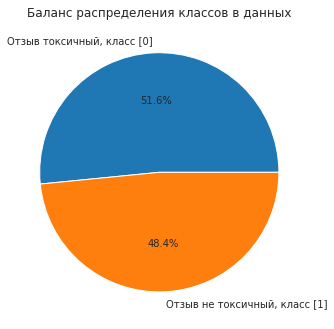

In [20]:
target_upsampled.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

In [21]:
#TF-IDF & nltk
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# corpus_lemm_train = features_upsampled['lemm_text'].values.astype('U')
# corpus_lemm_train.shape

In [23]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words,analyzer='word') 
tf_idf = count_tf_idf.fit_transform(features_upsampled['lemm_text']) 
tf_idf.shape

(109935, 110510)

In [24]:
corpus_lemm_valid = X_valid['lemm_text'].values
corpus_lemm_test = X_test['lemm_text'].values
corpus_lemm_test.shape

(27080,)

In [25]:
#Трансформируем тестовую выборку
tf_test = count_tf_idf.transform(corpus_lemm_test)
print(tf_test.shape)
# valid
tf_valid = count_tf_idf.transform(X_valid['lemm_text'])
print(tf_valid.shape)

(27080, 110510)
(27080, 110510)


Классы сильно разбилансированы в пользу негативных отзывов. Upsampled & downsampled избавят от возможной ошибки, когда отрицательный класс может быть принят за константу. 

## Обучение

In [26]:
#Функция графика плотности распределения предсказанных и истинных значений
def density_graph(true, predict):
    f1 = f1_score(y_test, predict)
    plt.figure(figsize=(10,6))
    true.plot(kind='kde', linewidth=3)
    pd.Series(predict).plot(kind='kde',linewidth=3)
    plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
    plt.legend(['Истинные значения','Предсказанные значения'])
    plt.text(0.75,6,'F1= {:.2f}'.format(f1))
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.show()

In [27]:
#Функция вызова матрицы предсказаний
def pred_matrix(data, color='blue'):
    attr = 'color: {}'.format(color)
    if data.ndim == 1:
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [28]:
def create_colors(x):
    df1 = x.copy()
    df1.loc[:,:] = 'background-color: '
    df1.loc['Predicted Positive(1)', 'Actually Negative(0)'] = 'background-color: coral'
    df1.loc['Predicted Negative(0)', 'Actually Positive(1)'] = 'background-color: coral' 
    df1.loc['Predicted Positive(1)', 'Actually Positive(1)'] = 'background-color: springgreen'
    df1.loc['Predicted Negative(0)','Actually Negative(0)'] = 'background-color: springgreen'

    return df1      

In [29]:
def conf_marix(predict):
    table = pd.DataFrame(index=['Predicted Positive(1)','Predicted Negative(0)',], columns=['Actually Positive(1)','Actually Negative(0)','Difference'])
    matrix = confusion_matrix(y_test, predict)
    table['Actually Positive(1)']['Predicted Positive(1)']= 'TP  {:.0f}'.format(matrix[0][0])
    table['Actually Positive(1)']['Predicted Negative(0)']= 'FN   {:.0f}'.format(matrix[1][0])

    table['Actually Negative(0)']['Predicted Positive(1)']= 'FP  {:.0f}'.format(matrix[0][1])
    table['Actually Negative(0)']['Predicted Negative(0)']= 'TN  {:.0f}'.format(matrix[1][1])
    
    table['Difference'][0] = abs(matrix[0][0] - matrix[0][1])
    table['Difference'][1] = abs(matrix[1][1]- matrix[1][0])
    return table.style.apply(create_colors, axis=None).apply(pred_matrix, subset=['Difference'])

In [30]:
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, scoring='f1')
clf.fit(tf_idf, target_upsampled)
tree_model = clf.best_estimator_
best_result_dt = clf.best_score_
best_depth_dt = clf.best_params_


print("F1 наилучшей модели равно:", best_result_dt.round(2), end='')
print(' C глубиной:',best_depth_dt)

F1 наилучшей модели равно: 0.69 C глубиной: {'max_depth': 19}


In [32]:
target_names=['Отзыв токсичный','Отзыв не токсичный']

model_dt = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dt['max_depth'])
model_dt.fit(tf_idf,target_upsampled)
predicted_dt = model_dt.predict(tf_valid)

f1_forest_1 = f1_score(y_valid, predicted_dt)
print(classification_report(y_valid, predicted_dt, target_names=target_names))
print('Метрика F1 качества предсказания модели "DecisionTreeClassifier" равна :',f1_forest_1.round(2))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.95      0.98      0.96     24270
Отзыв не токсичный       0.72      0.52      0.60      2810

          accuracy                           0.93     27080
         macro avg       0.83      0.75      0.78     27080
      weighted avg       0.92      0.93      0.92     27080

Метрика F1 качества предсказания модели "DecisionTreeClassifier" равна : 0.6


In [33]:
conf_marix(predicted_dt)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 22516,FP 1837,20679
Predicted Negative(0),FN 2550,TN 177,2373


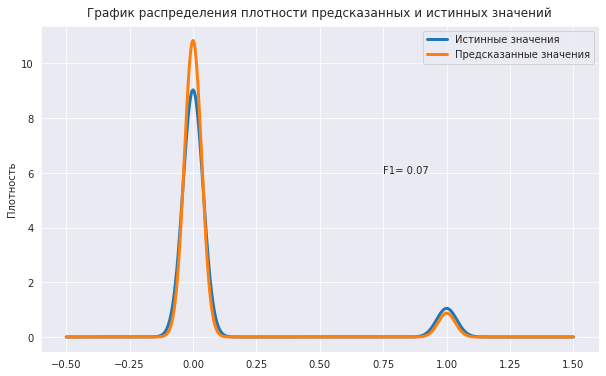

In [34]:
density_graph(y_valid,predicted_dt)

In [35]:
#LogisticRegression w GridSearchCV
clf_lr = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 10),
              'max_iter': range (10,15,2),
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(tf_idf, target_upsampled)
grid_lr.best_params_

{'C': 9, 'max_iter': 10}

In [37]:
predicted_lr = grid_lr.predict(tf_valid)

f1_log_r_1 = f1_score(y_valid, predicted_lr).round(2)
print(classification_report(y_valid, predicted_lr, target_names=target_names))
print('Метрика F1 качества предсказания модели "LogisticRegression" равна :',f1_log_r_1)

                    precision    recall  f1-score   support

   Отзыв токсичный       0.98      0.96      0.97     24270
Отзыв не токсичный       0.70      0.82      0.76      2810

          accuracy                           0.95     27080
         macro avg       0.84      0.89      0.86     27080
      weighted avg       0.95      0.95      0.95     27080

Метрика F1 качества предсказания модели "LogisticRegression" равна : 0.76


In [38]:
conf_marix(predicted_lr)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 21372,FP 2981,18391
Predicted Negative(0),FN 2414,TN 313,2101


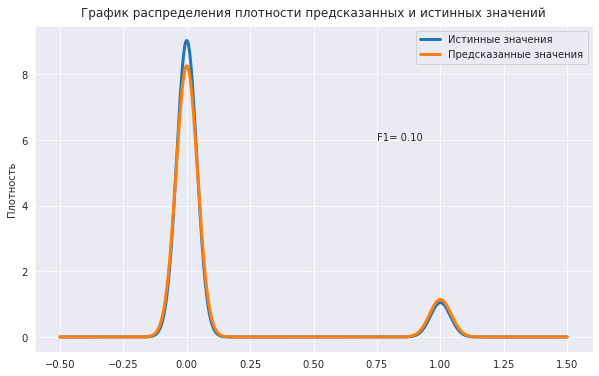

In [39]:
density_graph(y_valid,predicted_lr)

In [40]:
#RandomForestClassifier
best_model_rf = None
best_result_rf = 0
best_depth_rf=0
for est in tqdm(range(1, 12, 4)):
      
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=est,class_weight='balanced_subsample') 
    model_rf.fit(tf_idf,target_upsampled) 
    predict_rf=model_rf.predict(tf_valid) 
    result_rf = f1_score(y_valid, predict_rf)
    if result_rf > best_result_rf:
        best_model_rf = model_rf
        best_result_rf = result_rf
          
        best_depth_rf = est
print("F1 наилучшей модели равно:", best_result_rf.round(2), end='')
print('C глубиной:', best_depth_rf)

  0%|          | 0/3 [00:00<?, ?it/s]

F1 наилучшей модели равно: 0.65C глубиной: 9


In [41]:
predict_rfc = model_rf.predict(tf_valid)
f1_random_forest = f1_score(y_valid, predict_rfc)
print(classification_report(y_valid, predict_rfc, target_names=target_names))
print('Метрика F1 качества предсказания модели "RandomForestClassifier" равна :',f1_random_forest.round(2))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.96      0.97      0.96     24270
Отзыв не токсичный       0.68      0.62      0.65      2810

          accuracy                           0.93     27080
         macro avg       0.82      0.80      0.81     27080
      weighted avg       0.93      0.93      0.93     27080

Метрика F1 качества предсказания модели "RandomForestClassifier" равна : 0.65


In [42]:
conf_marix(predict_rfc)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 22024,FP 2329,19695
Predicted Negative(0),FN 2478,TN 249,2229


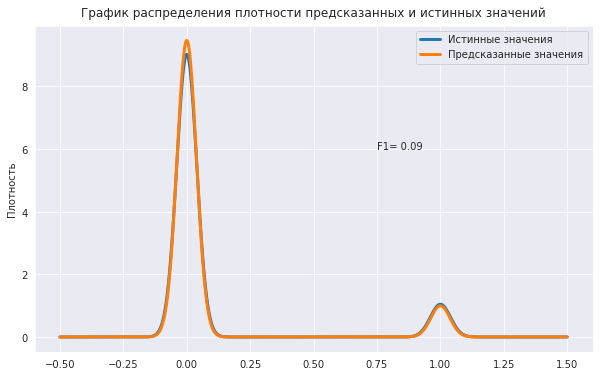

In [44]:
density_graph(y_valid, predict_rfc)

In [45]:
#Вероятность положительного класса
probability = grid_lr.predict_proba(tf_valid)
probability_one = probability[:, 1]
print("Вероятность:",probability_one[:5])

Вероятность: [0.19651513 0.03962875 0.09879361 0.0470457  0.03664939]


In [46]:
#Найдем порог классификации ### y_test > y_valid
for threshold in np.arange(0.4, 0.9, 0.02):
    predicted_v = probability_one > threshold
    precision = precision_score(y_valid, predicted_v)
    recall = recall_score(y_valid, predicted_v) 
    f1 = f1_score(y_test, predicted_v)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.40 | Точность = 0.650, Полнота = 0.857, F1 = 0.112
Порог = 0.42 | Точность = 0.660, Полнота = 0.852, F1 = 0.110
Порог = 0.44 | Точность = 0.670, Полнота = 0.847, F1 = 0.109
Порог = 0.46 | Точность = 0.682, Полнота = 0.840, F1 = 0.108
Порог = 0.48 | Точность = 0.692, Полнота = 0.833, F1 = 0.105
Порог = 0.50 | Точность = 0.703, Полнота = 0.825, F1 = 0.104
Порог = 0.52 | Точность = 0.713, Полнота = 0.819, F1 = 0.103
Порог = 0.54 | Точность = 0.721, Полнота = 0.815, F1 = 0.103
Порог = 0.56 | Точность = 0.733, Полнота = 0.808, F1 = 0.103
Порог = 0.58 | Точность = 0.744, Полнота = 0.802, F1 = 0.102
Порог = 0.60 | Точность = 0.752, Полнота = 0.796, F1 = 0.101
Порог = 0.62 | Точность = 0.759, Полнота = 0.789, F1 = 0.100
Порог = 0.64 | Точность = 0.767, Полнота = 0.784, F1 = 0.100
Порог = 0.66 | Точность = 0.774, Полнота = 0.775, F1 = 0.098
Порог = 0.68 | Точность = 0.789, Полнота = 0.768, F1 = 0.096
Порог = 0.70 | Точность = 0.800, Полнота = 0.762, F1 = 0.096
Порог = 0.72 | Точность 

In [47]:
predicted_rf_threshold = (probability_one>0.76)*1
print(classification_report(y_test,predicted_rf_threshold, target_names=target_names))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.90      0.91      0.90     24353
Отзыв не токсичный       0.10      0.09      0.09      2727

          accuracy                           0.83     27080
         macro avg       0.50      0.50      0.50     27080
      weighted avg       0.82      0.83      0.82     27080



In [48]:
#Отфильруем по порогу 0,76
predicted_test = (grid_lr.predict_proba(tf_test)[:,1] > 0.76)*1
f1_log_r_1 = f1_score(y_test, predicted_test).round(2)
print('Метрика F1 с порогом классификации:',f1_log_r_1)

Метрика F1 с порогом классификации: 0.77


In [49]:
conf_marix(predicted_test)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 23913,FP 440,23473
Predicted Negative(0),FN 749,TN 1978,1229


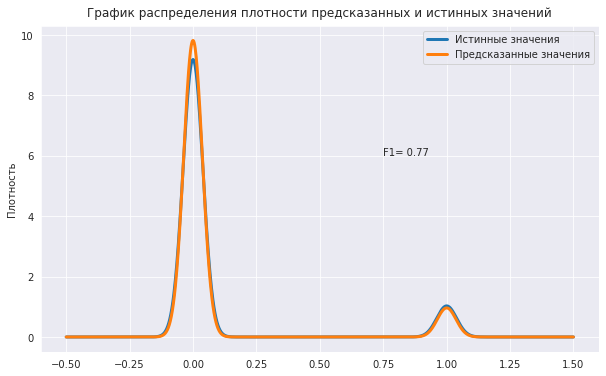

In [50]:
density_graph(y_test, predicted_test)

In [51]:
#ROC-AUC 
fpr, tpr, thresholds = roc_curve(y_test, probability_one)
auc_roc = roc_auc_score(y_test,probability_one)
print('ROC-AUC: {:.2f}'.format(auc_roc))

ROC-AUC: 0.50


## Выводы

In [52]:
#Таблица сравнения
comp_table = pd.DataFrame(index=['F1-мера'], columns=['Дерево решений','Cлучайный лес','Логистическая регрессия'])
comp_table['Дерево решений'] = best_result_dt.round(2)
comp_table['Cлучайный лес'] = f1_random_forest.round(2)
comp_table['Логистическая регрессия'] = f1_log_r_1
comp_table.T

,F1-мера
Дерево решений,0.69
Cлучайный лес,0.65
Логистическая регрессия,0.77


Задача для магазина "ВикиШоп" выполнена. Нужно было найти и обучить модель, которая сможет определить и разделить комментарии на негативные и позитивные для дальнейшей обработки негативных.     
Для работы был предоставлен набор набор данных с разметкой по токсичности, который отчистил от мусора и сбалансировал, т.к. сильный дисбаланс классов повлиял бы на качество предсказания.          
LogisticRegression показала лучший результат при обучении, затем результат улучшили, подобрав оптимальные параметры.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны